## M6 - W1 Assignment: Churn Problem Part 1

Churn is one of the most pressing issues in different industries. The idea is that we start understanding what a pipeline is and how we can use it to make our code more robust and less bug-prone. We will be using the following data set: https://www.kaggle.com/blastchar/telco-customer-churn.

We will explore the dataset a bit using most of what we learnt until now and start preparing everything for implementing and testing our models.

#### Questions we will answer

1) Have a quick overview of the features and implement a “cleaning process”. Make sure this part of the code is well organised, if possible make this an object-oriented exercise.

2) Explain the process that needs to happen for each feature before you train your model. Also, think about how future observations might be different from the ones you have!

3) Explain in your own words what is the importance of designing and implementing a pipeline? 

4) Choose one metric to evaluate the different models you will train and explain why you are choosing that instead of other traditional ones.

### Importing libraries

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore') # Repeated convergence warnings on Logistic Regression

In [2]:
#Import data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
#lower col names
data.columns = list(map(lambda column: column.lower(), data.columns))

#EDA
print(data.info())
print(data.head())
print('Shape: ', data.shape)
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerid          7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
tenure              7043 non-null int64
phoneservice        7043 non-null object
multiplelines       7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
contract            7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
churn               7043 non-null object
dtypes: float64(1), int64(2), obj

We have 7043 observations with 21 columns and no null values. Some values (`totalcharges`) need to be converted to a numerical value. There are categorical columns which will need to be converted to dummy values for the sake of using sklearn, eg. `gender`

### Data cleaning and transformation

##### Transform

We have cast columns to the categorical data type and filled in missing values as well as casting to numerical for the `totalcharges` column. Categorical data has been transformed to dummy variables to work with `sklearn`.

In [3]:
def transform(dataframe):
    df = dataframe.copy()
    df['seniorcitizen'] = df['seniorcitizen'].astype('category')
    #transform objects to ints total charge...
    df.totalcharges = df.totalcharges.str.replace(' ','')
    df.totalcharges = pd.to_numeric(df['totalcharges'])
    mean_totalcharges = np.mean(df['totalcharges'])
    df.totalcharges.fillna(mean_totalcharges, inplace=True)
    #get dummies
    df = pd.get_dummies(df.iloc[:,1:],drop_first=True)
    return df

data2 = transform(data)

### Heatmap

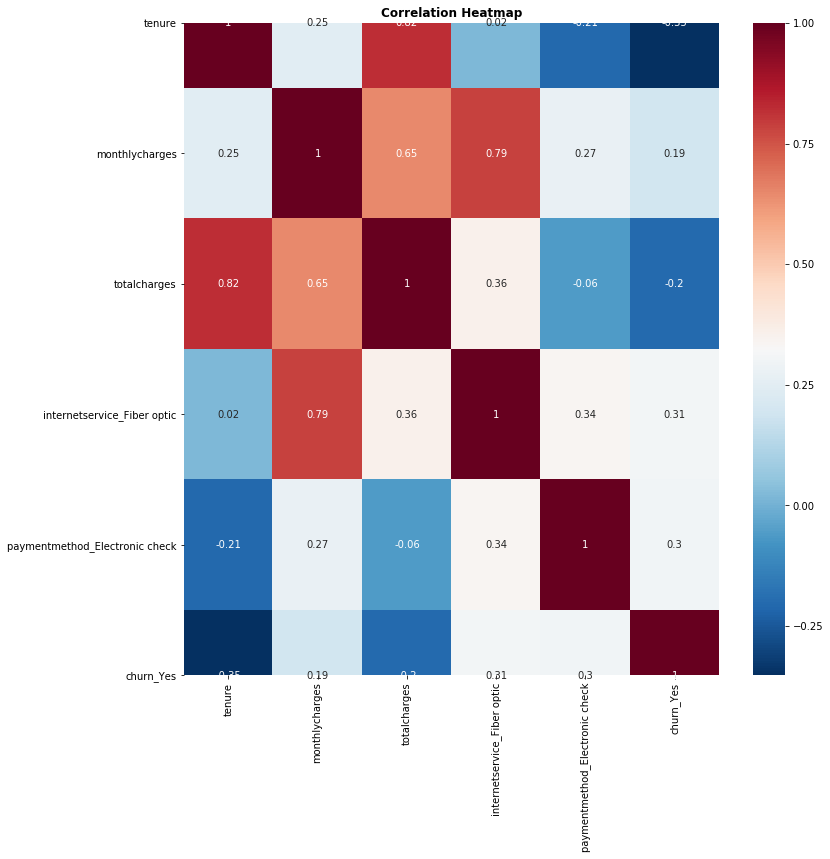

In [4]:
subset = data2.loc[:,['tenure', 'monthlycharges', 'totalcharges', \
                     'internetservice_Fiber optic', 'paymentmethod_Electronic check', 'churn_Yes']]
correlations = subset.corr()
_ = plt.figure(figsize=(12,12))
_ = sns.heatmap(correlations, annot=True, cmap='RdBu_r')
_ = plt.title('Correlation Heatmap', weight='bold', fontsize=12)
plt.show()

Churn is positively correlated to `paymentmethod_Electronic check`, `internetservice_Fiber optic` and `monthlycharges`. This means an increase in any of theses features will have an influence on customer churn. This means for those paying by electronic check or with fiber optic we expect to see more churn, as well as for those with higher monthly charges.

Negative correlations are observed between customer churn and the features `totalcharges` and `tenure` meaning the longer they've stayed and the more they've paid over time, the less likely they are to leave. We would also expect monthly charges and tenure to be strongly positively correlated, as the longer they have been with the company, the more they would have paid.

In [5]:
#function to split data into training and test data
def train_test(dataframe):
    df = dataframe.copy()
    y = df['churn_Yes']
    X = df.drop('churn_Yes', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

#Function to run pipeline and give output for particular classifier    
def pipe(dataframe, steps, params):
    df = dataframe.copy()
    X_train, X_test, y_train, y_test = train_test(df)
    pipe = Pipeline(steps)
    grid = RandomizedSearchCV(pipe, params, cv=5) #Very long computations when using GridSearch
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    best = grid.best_params_
    confusion = metrics.confusion_matrix(y_test, y_pred)
    clf = metrics.classification_report(y_test, y_pred)
    print('Confusion matrix for', steps[1][1], ': \n', confusion, '\n')
    print('Classification report for', steps[1][1], ': \n', clf, '\n')
    print('Best parameters for', steps[1][1], ': \n', best, '\n')

### Pipeline

Pipeline helps to make the workflow much easier to read and understand, and ensures the order of steps. This makes the work easier to reproduce.

Here we are using the pipeline to standardise the features and then apply the chosen classifier.

#### KNeighbors

Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

#### LogisticRegression

Logistic Regression is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (churn = yes in our case) or 0 (churn = no in our case).

In [6]:
#Determine best hyperparameters and run a confusion matrix and accuracy score on KNeighbors

steps = [('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]
params = {'classifier__n_neighbors' : np.arange(1, 11, 1)}
pipe(data2, steps, params)

Confusion matrix for KNeighborsClassifier() : 
 [[1536  161]
 [ 328  300]] 

Classification report for KNeighborsClassifier() : 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1697
           1       0.65      0.48      0.55       628

    accuracy                           0.79      2325
   macro avg       0.74      0.69      0.71      2325
weighted avg       0.78      0.79      0.78      2325
 

Best parameters for KNeighborsClassifier() : 
 {'classifier__n_neighbors': 10} 



In [7]:
steps = [('scaler', StandardScaler()), ('classifier', LogisticRegression())]
params = {'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
          'classifier__C' : np.linspace(1,7),
          'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
         }
pipe(data2, steps, params)

Confusion matrix for LogisticRegression() : 
 [[1528  169]
 [ 258  370]] 

Classification report for LogisticRegression() : 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1697
           1       0.69      0.59      0.63       628

    accuracy                           0.82      2325
   macro avg       0.77      0.74      0.76      2325
weighted avg       0.81      0.82      0.81      2325
 

Best parameters for LogisticRegression() : 
 {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 5.163265306122449} 



### Null accuracy

This is he accuracy that can be achieved by always predicting the most frequent class.

In [8]:
y = data2['churn_Yes']
# examine the class distribution of the testing set
print(y.value_counts())
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
print('percentage of ones: ', y.mean())
# calculate the percentage of zeroes
print('percentage of zeroes: ', 1 - y.mean())

0    5174
1    1869
Name: churn_Yes, dtype: int64
percentage of ones:  0.2653698707936959
percentage of zeroes:  0.7346301292063041


This means that a dumb model that always predicts 0 would be right 73% of the time.

### Conclusion (week 1)

Both models are above the null accuracy but using the confusion matrix and classification reprt we are able to determine that LogisticRegression is the more accurate model from the two we have chosen.

We have chosen to use `precision` as it gives an indication of the classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives, which can also be seen by referring to the confusion matrix.

### Week 2 

We will include the Logsitic Regression in this week's assignment as it came out with a good precision score above of 0.81.

We will be using `RandomForestClassifier` and `DecisionTreeClassifier` as looking at churn it is a classification problem - yes or no.

#### Random Forest Classifier

Random forest is able to handle both binary and continuous data which we have in our data. Also at each split of the tree, the model considers only a small subset of features rather than all of the features. That is a subset of m features (m=square root of total features) are selected at random. This is important so that variance can be averaged away. If there were a few strong predictors they will consistently be chosen at the top level of the trees, so we will have very similar structured trees. This will give us a low bias and moderate variance model.

#### Decision Tree Classifier

Decision Tree Classifier is easy to understand and interpret. It is one of the best approaches to identify most significant variables and the relationships between the variables. There is no need for data preprocessing, because decision trees are not influenced by outliers. The most important feature is that they can handle continuous numerical variables as well as categorical variables which we have both of in our data.

In [9]:
steps = [('scaler', StandardScaler()), ('classifier', RandomForestClassifier())]
params = {
    'classifier__n_estimators': [200,500],
    'classifier__max_features': [.5,.7],
    'classifier__bootstrap': [False, True],
    'classifier__max_depth':[3,6]
}
pipe(data2, steps, params)

Confusion matrix for RandomForestClassifier() : 
 [[1551  146]
 [ 312  316]] 

Classification report for RandomForestClassifier() : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1697
           1       0.68      0.50      0.58       628

    accuracy                           0.80      2325
   macro avg       0.76      0.71      0.73      2325
weighted avg       0.79      0.80      0.79      2325
 

Best parameters for RandomForestClassifier() : 
 {'classifier__n_estimators': 200, 'classifier__max_features': 0.5, 'classifier__max_depth': 6, 'classifier__bootstrap': False} 



In [10]:
steps = [('scaler', StandardScaler()), ('classifier', tree.DecisionTreeClassifier())]
params =[{'classifier__max_depth':np.arange(1,30),
             'classifier__min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]}]

pipe(data2, steps, params)

Confusion matrix for DecisionTreeClassifier() : 
 [[1565  132]
 [ 327  301]] 

Classification report for DecisionTreeClassifier() : 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1697
           1       0.70      0.48      0.57       628

    accuracy                           0.80      2325
   macro avg       0.76      0.70      0.72      2325
weighted avg       0.79      0.80      0.79      2325
 

Best parameters for DecisionTreeClassifier() : 
 {'classifier__min_samples_leaf': 100, 'classifier__max_depth': 28} 



### Conclusion (week 2)

Both trees are above the null accuracy and we can see that the random forest is showing slightly very similar accuracy of about 0.79 - 0.80 for weighted `precision`.

Logistic Regression is showing the best `precision` score though.

We have set the `GridSearchCV` to run at 5 folds to minimise any overfitting so believe this has minimise the effect of any over-fitting from the trained model.